In [9]:
import pandas as pd
import uproot
import numpy as np

# reading root file


#root_file = uproot.open("/home/nathan.regev/software/git_repo/G4_Nanophotonic_Scintillator/nonpriodic_sim_100000_photons_6layers202411141033153022956ed93096-c327-4699-947b-39acd0b63ecb.root")

root_file = uproot.open("/home/nathan.regev/software/git_repo/G4_Nanophotonic_Scintillator/bulk_sim_100000_repetitions.root")
photons = root_file["Photons"]

In [11]:
# Considering only optical photons
photonType = [t for t in photons["fType"].array()]
processType = [t for t in photons["fProcess"].array()]
#fStepStatusNumber=[t for t in photons["fStepStatusNumber"].array()]
status = [t for t in photons["fStepStatusNumber"].array()]
processType2 = [t for t in photons["fProcessType"].array()]
subSrocessType = [t for t in photons["fSubProcessType"].array()]
creatorProcess = [t for t in photons["fCreatorProcess"].array()]
trackID = [t for t in photons["ftrackID"].array()]
parentTrackID = [t for t in photons["fParentTrackID"].array()]
firstStep=[t for t in photons["FirstStep"].array()]
#stepIndex=[t for t in photons["step_index"].array()]
material = [t for t in photons["fMaterial"].array()]
relevant_ind = [t == 'Scintillation' for t in creatorProcess]
photonsX = np.array(photons["fX"].array())[relevant_ind]
photonsY = np.array(photons["fY"].array())[relevant_ind]
photonsZ = np.array(photons["fZ"].array())[relevant_ind]

trackToParticle_dict = {}
for particle, t_id in zip(photonType, trackID):
    trackToParticle_dict[t_id] = particle
parentParticle = [trackToParticle_dict[t_id] if t_id in trackID else "none" for t_id in parentTrackID]

def compute_hist(l):
    d = {}
    for t in l:
        if t not in d:
            d[t] = 1
        else:
            d[t] += 1
    return d

jointDict = compute_hist([p1 + ', ' + p2 + ', ' + str(p3) + ', ' + str(p4) + ', ' + str(p5)+ ', ' + str(p6)+ ', ' + str(p7)+ ', ' + str(p8)+ ', ' + str(p9)+ ', ' 
                          for ((((((((p1,p2), p3), p4), p5),p6),p7),p8),p9) in zip(zip(zip(zip(zip(zip(zip(zip(photonType, processType), material), parentParticle), creatorProcess),status),processType2),subSrocessType),firstStep)])
print("particle\tproces\t\tmaterial\tparentPar\tcreatorProc\tstatus\tprocessType2\tsubSrocessType\tfirst step\tstep index\tnum events\n")
for key, item in jointDict.items():
    line = '\t\t'.join([k[:6] for k in key.split(', ')]) + '\t\t' + str(item)
    print(line)
#electron_filter=[proces=='none' and creatorProc == 'phot'  for ((proces,creatorProc),ind) in zip(processType, creatorProcess)]
#print(np.sum(electron_filter))

particle	proces		material	parentPar	creatorProc	status	processType2	subSrocessType	first step	step index	num events

gamma		phot		PVT		none		none		4		2		12		1				21
lepton		none		PVT		gamma		phot		7		0		-1		1				298
optica		none		PVT		lepton		Scinti		7		0		-1		1				708
lepton		msc		PVT		gamma		phot		3		2		10		0				251
lepton		eIoni		PVT		gamma		phot		3		2		2		0				10
optica		none		PVT		gamma		Scinti		7		0		-1		1				8
gamma		compt		PVT		none		none		4		2		13		1				3
lepton		none		PVT		gamma		compt		7		0		-1		1				3
lepton		msc		PVT		gamma		compt		3		2		10		1				1
gamma		Rayl		PVT		none		none		4		2		11		1				1
lepton		msc		PVT		gamma		compt		3		2		10		0				2
lepton		eIoni		PVT		gamma		compt		3		2		2		0				2


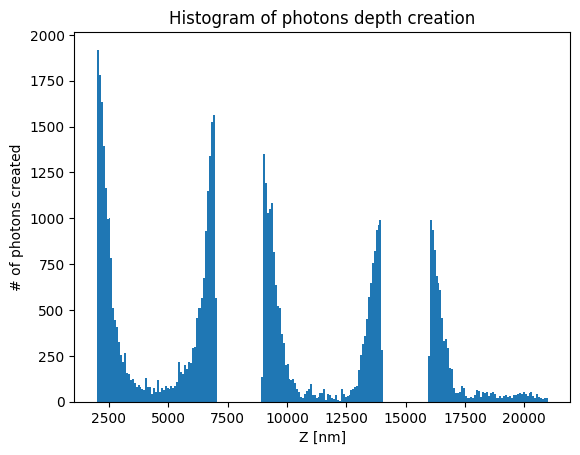

In [24]:
# Plot absorption as a function of the depth
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(photonsZ*1e6, bins=int(np.sqrt(len(photonsZ))))

ax.set_xlabel('Z [nm]')
ax.set_ylabel('# of photons created')
ax.set_title('Histogram of photons depth creation')
plt.show()

In [25]:
from scipy.stats import gaussian_kde
import multiprocessing
import os
os.environ['DISPLAY'] = 'localhost:10.0'

def calc_kde(data):
    return kde(data.T)

# Calculate kernel density estimation
photonsX_kde, photonsY_kde, photonsZ_kde = photonsX*1e6, photonsY*1e6, photonsZ*1e6
kde = gaussian_kde(np.row_stack((photonsX_kde, photonsY_kde, photonsZ_kde)))

# Evaluate kde on a grid
grid_size = 30j
factor = 30
xmin, ymin, zmin = photonsX_kde.min()/factor, photonsY_kde.min()/factor, photonsZ_kde.min()
xmax, ymax, zmax = photonsX_kde.max()/factor, photonsY_kde.max()/factor, photonsZ_kde.max()
xi, yi, zi = np.mgrid[xmin:xmax:grid_size, ymin:ymax:grid_size, zmin:zmax:grid_size]
coords = np.vstack([item.ravel() for item in [xi, yi, zi]]) 

# Multiprocessing
cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=cores)
results = pool.map(calc_kde, np.array_split(coords.T, 2))
density = np.concatenate(results).reshape(xi.shape)

/tmp/ipykernel_2520753/1292664615.py:11: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  kde = gaussian_kde(np.row_stack((photonsX_kde, photonsY_kde, photonsZ_kde)))


In [26]:
# Plot scatter with mayavi
from mayavi import mlab
figure = mlab.figure('DensityPlot', bgcolor=(1,1,1), fgcolor=(0,0,0))

grid = mlab.pipeline.scalar_field(xi, yi, zi, density)
mlab.pipeline.volume(grid, vmin=density.min() + .5*(density.max()-density.min()), vmax=density.min() + .9*(density.max()-density.min()))

mlab.axes()
mlab.show()

ModuleNotFoundError: No module named 'mayavi'

In [ ]:
import os
os.environ['DISPLAY'] = 'localhost:10.0'
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the transparency as a function of density
alpha = ((density - density.min()) / (density.max() - density.min()))**100

# Scatter plot the points with color based on density
ax.scatter(xi, yi, zi, c=density.flatten(), alpha=alpha.flatten(), cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Density of Photon Creation')
plt.show()